In [1]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
# tai from ... import *

# Database query

In [2]:
df = database_query("SELECT * FROM SensorData limit 10000")
df.head(5)

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


# Histogram of x and y coordinates

x mean:  1875.7078
y mean:  476.0527
x std:  879.9799080769742
y std:  1024.0719255612419


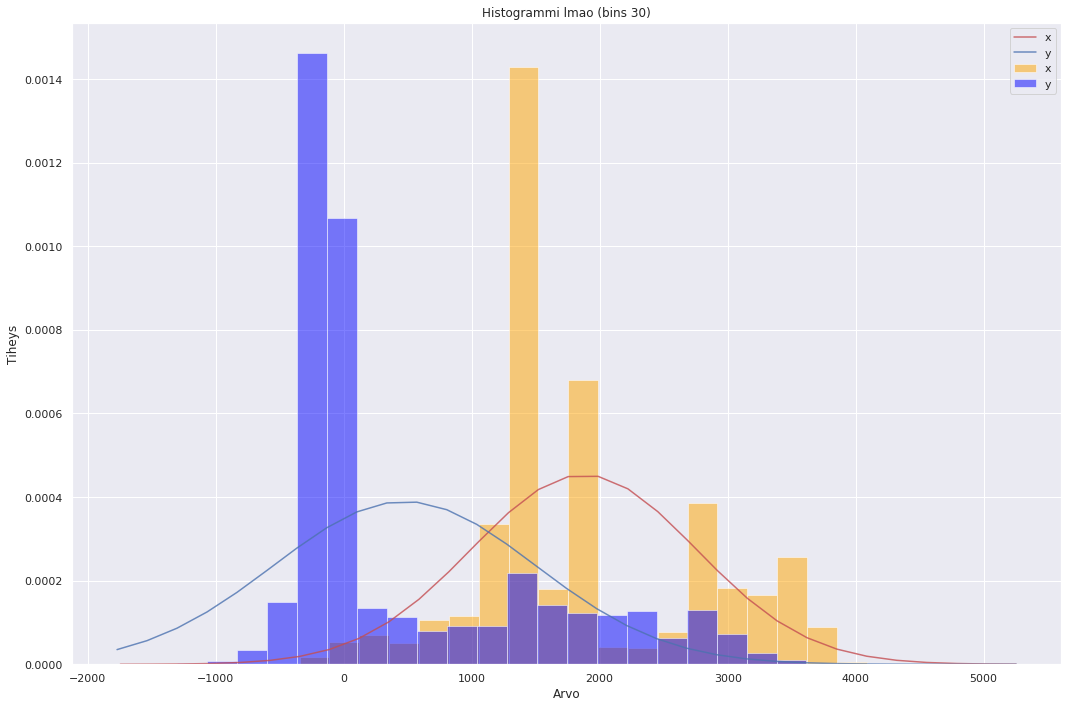

In [3]:
draw_histogram(df['x'], df['y'], 30)

# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 2549
uniques in y 2778
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  10000
Ouliers removed:     152
Data after:  9848


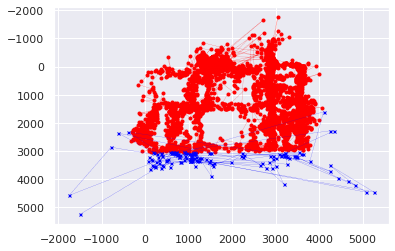

In [4]:
df1 = find_outliers(df)

# Cleaning Node_id, timestamp, q, z columns

In [5]:
df1 = clean_dataframe(df1)
df1.head(5)

,index,node_id,timestamp,x,y
0,0,1,2020-06-24 15:20:08.533,2762,-257
1,1,1,2020-06-24 15:20:08.620,2870,-344
2,2,1,2020-06-24 15:20:09.623,2916,-344
3,3,1,2020-06-24 15:20:09.623,2894,-254
4,4,1,2020-06-24 15:20:10.116,2888,-188


# Tehdään uuten tiedostoon Isolation Forestilla putsatut nodet

In [6]:
for i in range(32):
    df1_node = isolation_forest(df1, 0, .003, i+1)
    print('node numero', i+1, 'valmis')
    
    if i == 0:
        df1_node.to_csv('./temp_data.csv', index=False)
    else:
        df1_node.to_csv('./temp_data.csv',mode='a', header=False, index=False)

Dataframe lenght before: 9628
Dataframe lenght after: 9599
Total outliers detected: 29
node numero 1 valmis


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by MinMaxScaler.

In [7]:
df1 = pd.read_csv('./data/temp_data.csv')
df1 = df1.drop(columns='index')
df1.head(5)

FileNotFoundError: [Errno 2] File ./data/temp_data.csv does not exist: './data/temp_data.csv'

# Poistetaan vialliset / puutteelliset nodet

In [8]:
df1 = df1[df1.node_id != 13]
df1 = df1[df1.node_id != 14]
df1 = df1[df1.node_id != 18]
df1 = df1[df1.node_id != 32]

# Adding xy_grid values to dataframe (50x50)

In [9]:
grid_size = 50
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
df1.head()

,index,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,0,1,2020-06-24 15:20:08.533,2762,-257,34,15,784
1,1,1,2020-06-24 15:20:08.620,2870,-344,35,14,735
2,2,1,2020-06-24 15:20:09.623,2916,-344,36,14,736
3,3,1,2020-06-24 15:20:09.623,2894,-254,35,15,785
4,4,1,2020-06-24 15:20:10.116,2888,-188,35,16,835


# Write cleaned and diskretized dataframe to mariadb database

In [10]:
# Already writed, need to make update function
#write_df_to_mariadb(df1)

# Find and draw exits

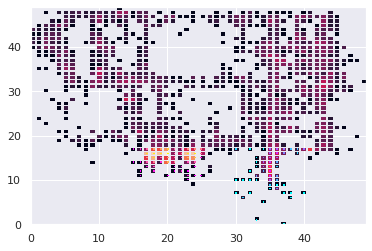

In [11]:
in_x, in_y = sisään(df1)
out_x, out_y = ulos(df1)

draw_exits(df1, in_x, in_y, out_x, out_y)

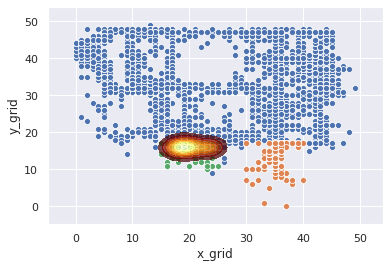

In [12]:
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# # Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()


### Erotetaan kauppareissut toisistaan

In [14]:
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)


reitit = poista_lyhyet_reitit(reitit, 50)
df_reitit = reitit_dataframeksi(reitit)


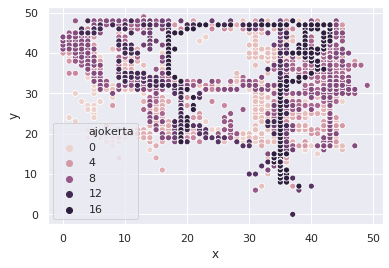

In [15]:
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

445


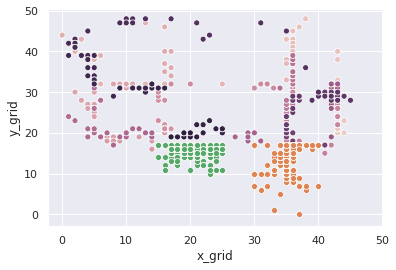

574


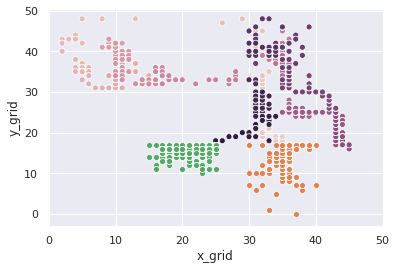

403


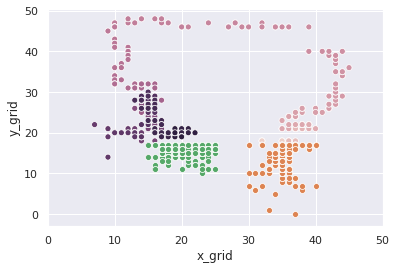

348


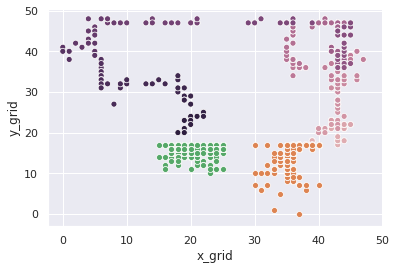

201


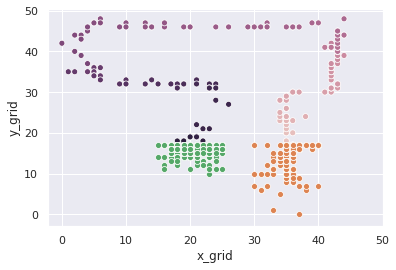

432


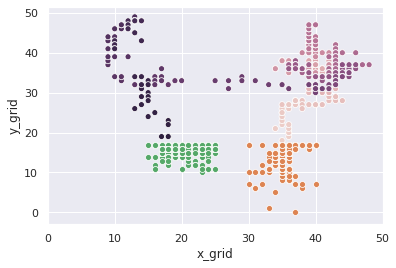

270


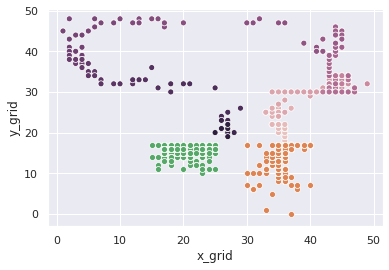

392


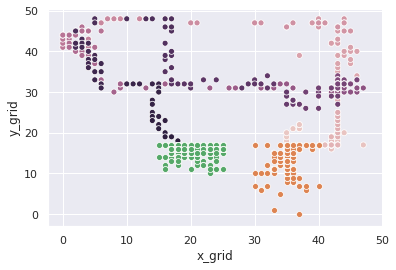

150


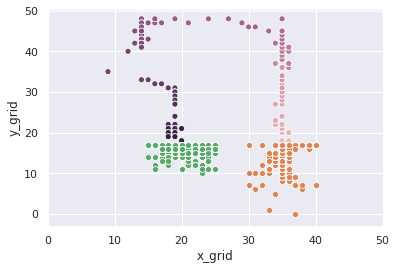

79


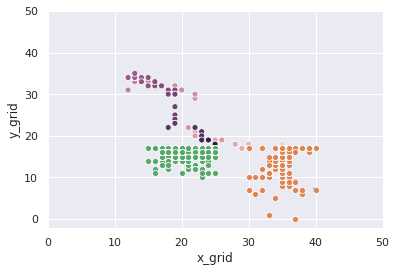

201


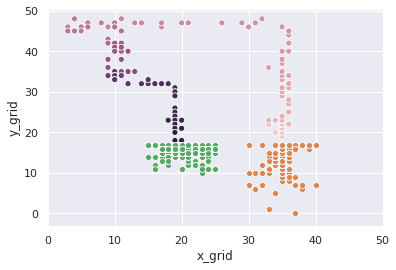

436


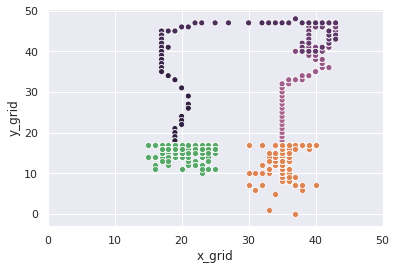

In [16]:
# Plottaa jokaisen kauppareissut erikseen.

plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y)   
# Ensimmäisissä on aika paljon häiriötä

In [49]:
lapimenoajat = get_lapimeno(reitit, 50)

Läpimenoajat [Timedelta('0 days 18:00:06.612000'), Timedelta('0 days 01:53:48.006000'), Timedelta('0 days 00:23:41.181000'), Timedelta('0 days 00:11:19'), Timedelta('0 days 00:40:12.999000'), Timedelta('0 days 00:09:23'), Timedelta('0 days 02:11:01.999000'), Timedelta('0 days 00:14:57.998000'), Timedelta('1 days 18:10:10.999000'), Timedelta('0 days 01:16:09.002000'), Timedelta('0 days 02:10:48.999000'), Timedelta('0 days 16:53:07.772000')]
